## Experimento 3. 
## Predicción de realizar un primer viaje migratorio hacia Estados Unidos

Selección y limpieza de datos a partir de la tabla <b>PERS</b>.

<b>PERS</b> es un archivo a nivel persona que provee información demográfica general e información sobre migración doméstica, a Estados Unidos, y a Canadá.

En este experimento se pretende obtener la probabilidad de realizar un primer viaje migratorio a Estados Unidos considerando la información contenida en el archivo <b>PERS</b>, calculando la probabilidad de realizar un primer viaje migratorio a partir del atributo <b>USYR1</b>, tomando el valor '8888' como <b>"no realizó un primer viaje migratorio"</b> y valores distintos a '8888' y '9999' como <b>"realizó un viaje migratorio"</b>.

Así, la etiqueta de clase puede tomar dos valores posibles:<br>
>1: Sí (Realizó primer viaje migratorio)<br>0: No (No realizó primer viaje migratorio)<br>

Para todos los clasificadores utilizados, se tomará la clase 1 (Realizó primer viaje migratorio) como clase **Positive**.

Se considera el cálculo de la probabilidad de realizar el primer viaje migratorio como el valor a obtener por los clasificadores utilizados, i.e. $P(\text{class = 1 | x})$ que se puede leer como la probabilidad de que la persona realice su primer viaje migratorio dadas las variables en el dataset.

Pata este experimento, se dividirá entre la clasificación entre hombres y mujeres, documentados e indocumentados siguiendo los resultados publicados por el MMP en: https://mmp.opr.princeton.edu/results/009firsttrippers-es.aspx

<br>

---

In [1]:
#Definición de clases Positive y Negative
#Formato: (clase, label)
    #clase: valor numérico
    #label: valor de texto (etiqueta)
#¿Realizó un primer viaje migratorio? (1: Sí, 0: No)
pos_class = (1, 'Sí') #Clase positive (Sí)
neg_class = (0, 'No') #Clase negative  (No)

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

sys.path.append(os.path.abspath(os.path.join('..'))) #Utils path
from tesis_experiments_utils import classifiers_utils as cu
from tesis_experiments_utils import confusion_matrices_utils as cmu
from tesis_experiments_utils import data_utils as du
from tesis_experiments_utils import files_utils as fu
from tesis_experiments_utils import learning_curves_utils as lcu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTENC

Crear carpetas para almacenar datos imputados y 

In [3]:
fu.setup_folders()

La carpeta 'particiones/hold_out' ya existe
La carpeta 'datos_imputados' ya existe
La carpeta 'matrices_de_confusion' ya existe
La carpeta 'curvas_de_aprendizaje' ya existe
La carpeta 'resultados' ya existe


### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

Variables para la lectura del dataset

In [4]:
#Ubicación del dataset
path_to_data = os.path.join('..', 'datasets')
path_to_file = os.path.join(path_to_data,'prob_mexicanos_primer_viaje', 'pers.csv')

#Atributos categóricos del dataset
cat_atts = ['sex', 'relhead', 'yrborn', 'statebrn', 'placebrn', 'marstat', 'occ', '@by']

## Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

### Hold Out

Realizar partición de datos con Hold-out

In [6]:
X_train, X_test, y_train, y_test = du.stratified_hold_out(path_to_file, cat_atts, test_size=0.2)
X = pd.concat([X_train, X_test])

Partición de datos hold out 0.80-0.20 encontrada en 'particiones/hold_out'
Partición de datos cargada exitosamente desde el directorio 'particiones/hold_out/0.80_0.20'


### K-fold Cross Validation

In [7]:
kf_cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

### Cálculo de Imbalance Ratio

In [8]:
y = np.concatenate((y_train, y_test))

card_class1 = sum(1 for l in y if l == pos_class[0]) #Cardinalidad de la clase Positive
card_class2 = sum(1 for l in y if l == neg_class[0]) #Cardinalidad de la clase Negative

IR = max(card_class1,card_class2)/min(card_class1,card_class2)

print("Instancias en el dataset: %i" % len(y))
print("Cadinalidad de la clase Positive: %i" % card_class1)
print("Cadinalidad de la clase Negative: %i" % card_class2)


if(IR <= 1.5):
  print("Dataset balanceado con IR = %.4f" % IR)
else:
  print("Dataset desbalanceado con IR = %.4f" % IR)


Instancias en el dataset: 175874
Cadinalidad de la clase Positive: 27511
Cadinalidad de la clase Negative: 148363
Dataset desbalanceado con IR = 5.3929


## Imputación de datos perdidos

In [9]:
X_train, X_test = du.impute_data(X_train, X_test, cat_atts,'median')

Datos imputados con estrategia 'median' encontrados en 'datos_imputados'
Datos imputados cargados exitosamente desde 'datos_imputados'


## Balanceo de clases

In [10]:
smote_nc  = SMOTENC(random_state=42, categorical_features=cat_atts) #SMOTENC
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

## Normalización del dataset para utilizarlo con clasificadores basádos en métricas

Normalización de los atributos del dataset utilizando la forma:

$
    \Large z = \frac{(x-\mu)}{\sigma}
$

También conocida como z-score

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

## One hot encoding sobre atributos categóricos para utilizarlo con clasificadores basados en reglas

In [12]:
encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')
#pd.concat(atributos no categóricos, atributos categóricos codificados, nombre de columnas, axis)
X_train_encoded = pd.concat([X_train.drop(cat_atts, axis=1), 
                             pd.DataFrame(encoder.fit_transform(X_train[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_atts, axis=1),
                            pd.DataFrame(encoder.transform(X_test[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)

/home/daniel/anaconda3/envs/migration/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Medidas de desempeño para cross validation y learning curve

In [13]:
scoring = ['accuracy', 'matthews_corrcoef'] #Métricas de evaluación para selección de modelos
score_validation = 'accuracy' #Métrica de evaluación para learning curve

# Clasificadores k-NN

### **Elección del parámetro k**

Elección del parámetro k que minimiza el error de generalización utilizando *10-fold cross validation* a partir del Coeficiente de Correlación de Matthews.

In [13]:
k_range = range(1,52,2)
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params = {'n_neighbors': k_range, 'metric': metrics}
knn = KNeighborsClassifier()

best_knn = GridSearchCV(knn,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit = score_validation, verbose=3)
best_knn.fit(X_train_scaled, y_train)
best_mcc = best_knn.best_score_
best_k = best_knn.best_params_['n_neighbors']
best_metric = best_knn.best_params_['metric']

print(f'Mejor k: {best_k}, mejor métrica: {best_metric}, MCC media: {best_mcc:.4f}.')

Fitting 10 folds for each of 104 candidates, totalling 1040 fits
[CV 10/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.858) matthews_corrcoef: (test=0.716) total time=  13.8s
[CV 9/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.861) matthews_corrcoef: (test=0.722) total time=  14.9s
[CV 8/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.860) matthews_corrcoef: (test=0.720) total time=  15.1s
[CV 2/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.858) matthews_corrcoef: (test=0.716) total time=  15.2s
[CV 4/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.859) matthews_corrcoef: (test=0.719) total time=  15.3s
[CV 1/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.859) matthews_corrcoef: (test=0.717) total time=  15.3s
[CV 6/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.856) matthews_corrcoef: (test=0.712) total time=  15.4s
[CV 3/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.862) matthews_corrcoef

Curvas de aprendizaje del clasificador 1-NN almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


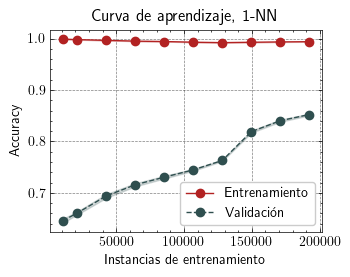

In [14]:
#best_k = 7
knn = KNeighborsClassifier(n_neighbors=best_k) 
lcu.plot_and_save_learning_curve(knn, f'{best_k}-NN',X_train_scaled, y_train, scoring = score_validation, cv=kf_cv_10, y_label="Accuracy")

Resultados del clasificador 1-NN almacenados en resultados/resultados.csv
Predicciones del clasificador 1-NN almacenadas en resultados/predicciones.csv.
Accuracy: 0.7997
Balanced accuracy: 0.6814
Recall: 0.5093
Specificity: 0.8536
AUC: 0.5093
MCC: 0.3276
Precision: 0.3921
F1-score: 0.4430


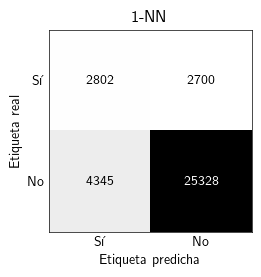

In [15]:
cu.train_and_evaluate_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, f'{best_k}-NN',pos_class,neg_class)

# Naïve Bayes

### **Naïve Bayes**

Curvas de aprendizaje del clasificador Naïve Bayes almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


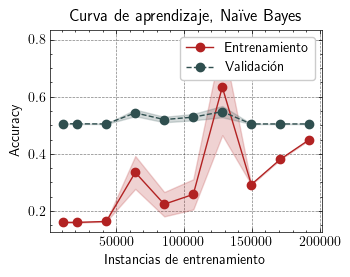

In [16]:
nb = GaussianNB()
lcu.plot_and_save_learning_curve(nb,'Naïve Bayes', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label="Accuracy")

Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Predicciones del clasificador Naïve Bayes almacenadas en resultados/predicciones.csv.
Accuracy: 0.1649
Balanced accuracy: 0.5049
Recall: 0.9998
Specificity: 0.0100
AUC: 0.9998
MCC: 0.0390
Precision: 0.1577
F1-score: 0.2725


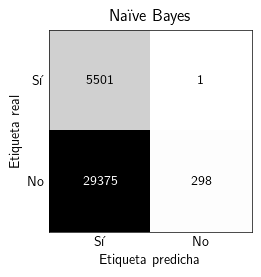

In [17]:
cu.train_and_evaluate_model(nb, X_train_encoded, y_train, X_test_encoded, y_test, 'Naïve Bayes',pos_class,neg_class)

# Decision Tree

In [18]:
depth_range = range(1,52)
params = {'max_depth': depth_range}

dtree = DecisionTreeClassifier()
best_tree = GridSearchCV(dtree, params, scoring=scoring, cv=kf_cv_10, n_jobs=-1, pre_dispatch=4, refit = score_validation, verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_score = best_tree.best_score_
best_depth = best_tree.best_params_['max_depth']

print(f'Best {score_validation}: {best_score}, best depth: {best_depth}')

Fitting 10 folds for each of 51 candidates, totalling 510 fits
[CV 4/10] END max_depth=1; accuracy: (test=0.651) matthews_corrcoef: (test=0.390) total time=   1.2s
[CV 2/10] END max_depth=1; accuracy: (test=0.652) matthews_corrcoef: (test=0.390) total time=   1.2s
[CV 1/10] END max_depth=1; accuracy: (test=0.649) matthews_corrcoef: (test=0.385) total time=   1.2s
[CV 3/10] END max_depth=1; accuracy: (test=0.650) matthews_corrcoef: (test=0.388) total time=   1.2s
[CV 6/10] END max_depth=1; accuracy: (test=0.649) matthews_corrcoef: (test=0.384) total time=   1.2s
[CV 7/10] END max_depth=1; accuracy: (test=0.654) matthews_corrcoef: (test=0.392) total time=   1.2s
[CV 5/10] END max_depth=1; accuracy: (test=0.648) matthews_corrcoef: (test=0.382) total time=   1.2s
[CV 8/10] END max_depth=1; accuracy: (test=0.650) matthews_corrcoef: (test=0.386) total time=   1.2s
[CV 10/10] END max_depth=1; accuracy: (test=0.650) matthews_corrcoef: (test=0.386) total time=   1.2s
[CV 9/10] END max_depth=1; 

In [19]:
min_samples_split_range = range(2,41)
min_samples_leaf_range = range(1,21)
params = {'min_samples_split': min_samples_split_range, 'min_samples_leaf':min_samples_leaf_range}

dtree = DecisionTreeClassifier(max_depth=best_depth)

#No se requieren las métricas de entrenamiento
best_tree = GridSearchCV(dtree, params, scoring=scoring, cv=kf_cv_10, n_jobs=-1, pre_dispatch=4, refit = score_validation, verbose=3)
best_tree.fit(X_train_encoded, y_train)
best_score = best_tree.best_score_
best_min_samples_split = best_tree.best_params_['min_samples_split']
best_min_samples_leaf = best_tree.best_params_['min_samples_leaf']

Fitting 10 folds for each of 780 candidates, totalling 7800 fits
[CV 2/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.883) matthews_corrcoef: (test=0.765) total time=   6.4s
[CV 1/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.889) matthews_corrcoef: (test=0.778) total time=   6.5s
[CV 4/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.885) matthews_corrcoef: (test=0.770) total time=   6.7s
[CV 3/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.889) matthews_corrcoef: (test=0.778) total time=   6.9s
[CV 5/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.888) matthews_corrcoef: (test=0.776) total time=   6.6s
[CV 6/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.889) matthews_corrcoef: (test=0.778) total time=   6.6s
[CV 7/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.889) matthews_corrcoef: (test=0.779) total time=   6.4s
[CV 8/10] END min_samples_leaf=1

In [20]:
print(f'Best depth: {best_depth}, Best min_samples_split: {best_min_samples_split}, Best min_samples_leaf: {best_min_samples_leaf}, Best {score_validation}: {best_score}')

Best depth: 36, Best min_samples_split: 3, Best min_samples_leaf: 1, Best accuracy: 0.886987109276266


Curvas de aprendizaje del clasificador Decision Tree almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


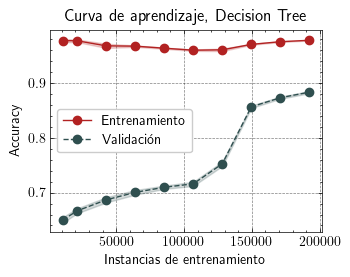

In [21]:
dtree = DecisionTreeClassifier(splitter="best", max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
lcu.plot_and_save_learning_curve(dtree, 'Decision Tree', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label="Accuracy")

Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Predicciones del clasificador Decision Tree almacenadas en resultados/predicciones.csv.
Accuracy: 0.8302
Balanced accuracy: 0.6743
Recall: 0.4475
Specificity: 0.9011
AUC: 0.4475
MCC: 0.3514
Precision: 0.4563
F1-score: 0.4518


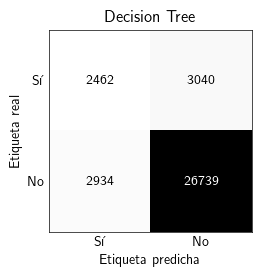

In [22]:
cu.train_and_evaluate_model(dtree, X_train_encoded, y_train, X_test_encoded, y_test, 'Decision Tree', pos_class, neg_class)

# Random Forest

In [23]:
rf = RandomForestClassifier(bootstrap=True, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
n_estimators_range = range(100,1100,100)
params = {'n_estimators': n_estimators_range}

best_rf = GridSearchCV(rf,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, pre_dispatch=3, refit = score_validation, verbose=3)
best_rf.fit(X_train_encoded, y_train) 
best_score = best_tree.best_score_
best_n_estimators = best_rf.best_params_['n_estimators']

print(f'Best {score_validation}: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 3/10] END n_estimators=100; accuracy: (test=0.855) matthews_corrcoef: (test=0.714) total time=  26.0s
[CV 2/10] END n_estimators=100; accuracy: (test=0.854) matthews_corrcoef: (test=0.712) total time=  26.3s
[CV 1/10] END n_estimators=100; accuracy: (test=0.855) matthews_corrcoef: (test=0.714) total time=  26.4s
[CV 6/10] END n_estimators=100; accuracy: (test=0.853) matthews_corrcoef: (test=0.710) total time=  26.0s
[CV 4/10] END n_estimators=100; accuracy: (test=0.856) matthews_corrcoef: (test=0.715) total time=  26.4s
[CV 5/10] END n_estimators=100; accuracy: (test=0.856) matthews_corrcoef: (test=0.715) total time=  26.4s
[CV 8/10] END n_estimators=100; accuracy: (test=0.854) matthews_corrcoef: (test=0.712) total time=  26.2s
[CV 7/10] END n_estimators=100; accuracy: (test=0.855) matthews_corrcoef: (test=0.713) total time=  26.3s
[CV 9/10] END n_estimators=100; accuracy: (test=0.851) matthews_corrcoef: (test=0.706) to

Curvas de aprendizaje del clasificador Random Forest almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


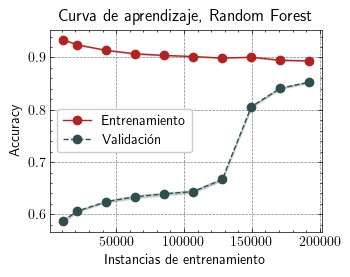

In [14]:
best_n_estimators = 900
best_depth= 36
best_min_samples_split= 3
best_min_samples_leaf = 1
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
lcu.plot_and_save_learning_curve(rf, 'Random Forest', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label="Accuracy", n_jobs=-1, pre_dispatch=3)

Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Predicciones del clasificador Random Forest almacenadas en resultados/predicciones.csv.
Accuracy: 0.7945
Balanced accuracy: 0.7637
Recall: 0.7188
Specificity: 0.8085
AUC: 0.7188
MCC: 0.4295
Precision: 0.4104
F1-score: 0.5225


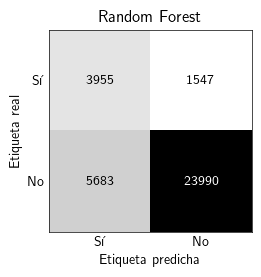

In [15]:
cu.train_and_evaluate_model(rf, X_train_encoded, y_train, X_test_encoded, y_test, 'Random Forest',pos_class,neg_class)

# Gradient Boosting Machine (GBM)

In [18]:
gbm =  GradientBoostingClassifier(criterion='friedman_mse')
n_estimators_range = range(1000,1500,100)
params = {'n_estimators': n_estimators_range}

best_gbm = GridSearchCV(gbm,params, scoring=scoring, cv=kf_cv_10 ,n_jobs=-1, pre_dispatch=13, refit = score_validation, verbose=3)
best_gbm.fit(X_train_scaled, y_train) 
best_score = best_gbm.best_score_
best_n_estimators = best_gbm.best_params_['n_estimators']

print(f'Best {score_validation}: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[CV 6/10] END n_estimators=1000; accuracy: (test=0.907) matthews_corrcoef: (test=0.815) total time= 3.8min
[CV 8/10] END n_estimators=1000; accuracy: (test=0.906) matthews_corrcoef: (test=0.812) total time= 3.8min
[CV 9/10] END n_estimators=1000; accuracy: (test=0.903) matthews_corrcoef: (test=0.807) total time= 4.0min
[CV 4/10] END n_estimators=1000; accuracy: (test=0.905) matthews_corrcoef: (test=0.811) total time= 4.8min
[CV 7/10] END n_estimators=1000; accuracy: (test=0.905) matthews_corrcoef: (test=0.811) total time= 4.8min
[CV 3/10] END n_estimators=1000; accuracy: (test=0.906) matthews_corrcoef: (test=0.814) total time= 4.9min
[CV 1/10] END n_estimators=1000; accuracy: (test=0.903) matthews_corrcoef: (test=0.807) total time= 5.0min
[CV 10/10] END n_estimators=1000; accuracy: (test=0.906) matthews_corrcoef: (test=0.814) total time= 5.1min
[CV 2/10] END n_estimators=1000; accuracy: (test=0.904) matthews_corrcoef: (test=0.810) total time= 5.1min
[CV 5/10] END n_estimators=1000; acc

Curvas de aprendizaje del clasificador GBM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


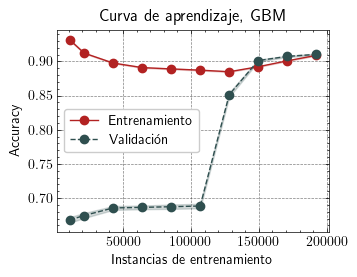

In [19]:
#best_n_estimators = 1400
gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
lcu.plot_and_save_learning_curve(gbm, 'GBM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, y_label="Accuracy")

Resultados del clasificador GBM almacenados en resultados/resultados.csv
Predicciones del clasificador GBM almacenadas en resultados/predicciones.csv.
Accuracy: 0.8681
Balanced accuracy: 0.7104
Recall: 0.4807
Specificity: 0.9400
AUC: 0.4807
MCC: 0.4608
Precision: 0.5976
F1-score: 0.5328


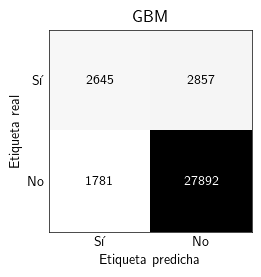

In [20]:
#best_n_estimators = 10000
#gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
cu.train_and_evaluate_model(gbm, X_train_scaled, y_train, X_test_scaled, y_test, 'GBM', pos_class, neg_class)

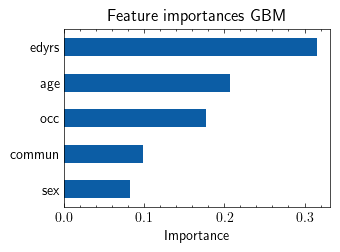

In [21]:
features=X_train_scaled.columns.to_list()
feature_imp = gbm.feature_importances_

df_feature_imp = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Feature importances GBM')
    ax.set_xlabel('Importance')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_gbm.png'), dpi=300, bbox_inches='tight')
plt.show()

# Multi Layer Perceptron (MLP)

In [22]:
mlp =  MLPClassifier(activation='relu', max_iter=2000, solver='sgd', learning_rate='adaptive')
#hidden_layers_range = [(1000,45,),(2000,55,),(3000,65,),(4000,75,), (5000,85,), (6000,95,), (7000,105,), (8000,115,), (9000,125,), (10000,135,)]
hidden_layers_range = [(55,25),(55,30),(60,25),(60,30),(65,25),(65,30),(70,25),(70,30),(75,25),(75,30),(80,25),(80,30),
                       (85,25),(85,30),(90,25),(90,30),(95,25),(95,30),(100,25),(100,30)] #Número de neuronas en dos capas ocultas del MLP
params = {'hidden_layer_sizes': hidden_layers_range}

best_mlp = GridSearchCV(mlp,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, pre_dispatch=13, refit = score_validation, verbose=3)
best_mlp.fit(X_train_scaled, y_train) 
best_score = best_mlp.best_score_
best_hidden_layers = best_mlp.best_params_['hidden_layer_sizes']

print(f'Best {score_validation}: {best_score}, best n. estimators: {best_hidden_layers}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 8/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.779) matthews_corrcoef: (test=0.560) total time= 1.8min
[CV 9/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.779) matthews_corrcoef: (test=0.561) total time= 2.2min
[CV 5/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.776) matthews_corrcoef: (test=0.554) total time= 2.3min
[CV 10/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.777) matthews_corrcoef: (test=0.555) total time= 2.5min
[CV 4/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.776) matthews_corrcoef: (test=0.553) total time= 2.6min
[CV 1/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.777) matthews_corrcoef: (test=0.556) total time= 2.7min
[CV 1/10] END hidden_layer_sizes=(55, 30); accuracy: (test=0.787) matthews_corrcoef: (test=0.576) total time= 3.3min
[CV 7/10] END hidden_layer_sizes=(55, 25); accuracy: (test=0.783) matthews_corrcoef: (test=0.568) total time= 3.5min


Curvas de aprendizaje del clasificador MLP almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


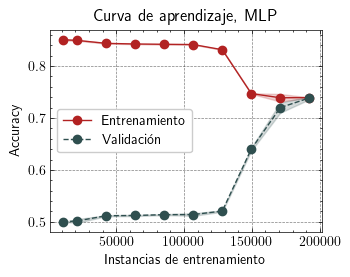

In [23]:
#best_hidden_layers = (7000, 105)
#original = (1000,45,)
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation='logistic', max_iter=2000, solver='sgd', learning_rate='adaptive')
lcu.plot_and_save_learning_curve(mlp, 'MLP', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, y_label="Accuracy")
#90 minutos

Iteration 1, loss = 0.58766022
Iteration 2, loss = 0.53685720
Iteration 3, loss = 0.52270866
Iteration 4, loss = 0.51599198
Iteration 5, loss = 0.51198398
Iteration 6, loss = 0.50925225
Iteration 7, loss = 0.50729275
Iteration 8, loss = 0.50577015
Iteration 9, loss = 0.50456161
Iteration 10, loss = 0.50347133
Iteration 11, loss = 0.50256409
Iteration 12, loss = 0.50172070
Iteration 13, loss = 0.50093313
Iteration 14, loss = 0.50018986
Iteration 15, loss = 0.49951751
Iteration 16, loss = 0.49885337
Iteration 17, loss = 0.49815902
Iteration 18, loss = 0.49758341
Iteration 19, loss = 0.49705411
Iteration 20, loss = 0.49653658
Iteration 21, loss = 0.49605064
Iteration 22, loss = 0.49553256
Iteration 23, loss = 0.49508471
Iteration 24, loss = 0.49461297
Iteration 25, loss = 0.49416837
Iteration 26, loss = 0.49373778
Iteration 27, loss = 0.49335642
Iteration 28, loss = 0.49294078
Iteration 29, loss = 0.49253215
Iteration 30, loss = 0.49215442
Iteration 31, loss = 0.49164609
Iteration 32, los

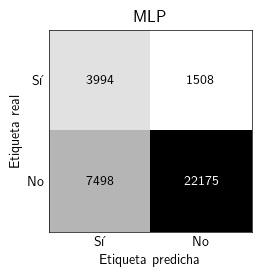

In [24]:
#hidden_layers = (39,23,11)
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation='relu', max_iter=2000, solver='sgd', learning_rate='adaptive', verbose=True)
mlp.out_activation_ = 'logistic'
cu.train_and_evaluate_model(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP', pos_class, neg_class)

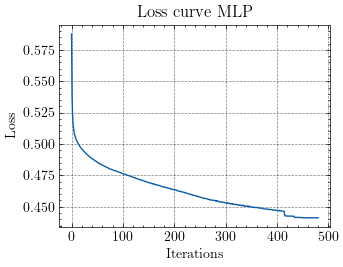

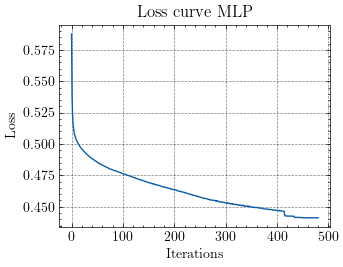

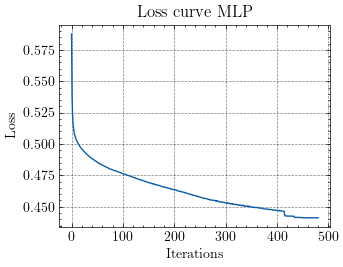

In [27]:
with plt.style.context(['science','grid']):
    fig, ax = plt.subplots()
    ax.plot(mlp.loss_curve_)
    ax.set_title('Loss curve MLP')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.savefig('curvas_de_aprendizaje/MLP_loss_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

# Support Vector Machines (SVMs)

## SVM con kernel lineal

## SVM con kernel RBF Gaussiana

In [28]:
rsvm = SVC(kernel='rbf')
C_range = np.logspace(-3, 0, 7)
gamma_range = np.logspace(-3, 0, 7)
params = {'C': C_range, 'gamma': gamma_range}
best_rsvm = GridSearchCV(rsvm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit = score_validation, verbose=3)
best_rsvm.fit(X_train_scaled, y_train)
best_mcc = best_rsvm.best_score_
best_C = best_rsvm.best_params_['C']
best_gamma = best_rsvm.best_params_['gamma']
print(f'Best MCC: {best_mcc}, best C: {best_C}, best gamma: {best_gamma}')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV 5/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.687) matthews_corrcoef: (test=0.376) total time=72.0min
[CV 6/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.687) matthews_corrcoef: (test=0.376) total time=72.2min
[CV 10/10] END C=0.001, gamma=0.001; accuracy: (test=0.617) matthews_corrcoef: (test=0.310) total time=74.8min
[CV 3/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.689) matthews_corrcoef: (test=0.380) total time=76.0min
[CV 4/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.689) matthews_corrcoef: (test=0.379) total time=76.5min
[CV 9/10] END C=0.001, gamma=0.001; accuracy: (test=0.617) matthews_corrcoef: (test=0.302) total time=77.1min
[CV 1/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.692) matthews_corrcoef: (test=0.386) total time=77.2min
[CV 1/10] END C=0.001, gamma=0.001; accuracy: (test=0.623) matthews_corrcoef: (test=0.

/home/daniel/anaconda3/envs/migration/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/10] END C=0.001, gamma=0.31622776601683794; accuracy: (test=0.731) matthews_corrcoef: (test=0.461) total time=82.7min
[CV 9/10] END C=0.001, gamma=0.31622776601683794; accuracy: (test=0.730) matthews_corrcoef: (test=0.459) total time=75.6min
[CV 10/10] END C=0.001, gamma=0.09999999999999999; accuracy: (test=0.726) matthews_corrcoef: (test=0.453) total time=87.1min
[CV 2/10] END C=0.001, gamma=0.31622776601683794; accuracy: (test=0.732) matthews_corrcoef: (test=0.464) total time=89.9min
[CV 1/10] END C=0.001, gamma=1.0; accuracy: (test=0.738) matthews_corrcoef: (test=0.476) total time=82.3min
[CV 2/10] END C=0.001, gamma=1.0; accuracy: (test=0.737) matthews_corrcoef: (test=0.474) total time=87.0min
[CV 3/10] END C=0.001, gamma=1.0; accuracy: (test=0.738) matthews_corrcoef: (test=0.476) total time=84.4min
[CV 4/10] END C=0.001, gamma=1.0; accuracy: (test=0.738) matthews_corrcoef: (test=0.476) total time=84.6min
[CV 5/10] END C=0.001, gamma=1.0; accuracy: (test=0.742) matthews_corrc

Curvas de aprendizaje del clasificador RBF SVM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


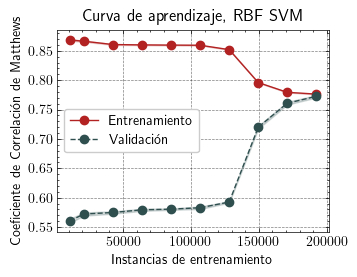

In [29]:
rsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
lcu.plot_and_save_learning_curve(rsvm, 'RBF SVM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, n_jobs=-1)

Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Predicciones del clasificador RBF SVM almacenadas en resultados/predicciones.csv.
Accuracy: 0.7276
Balanced accuracy: 0.7297
Recall: 0.7326
Specificity: 0.7267
AUC: 0.7326
MCC: 0.3510
Precision: 0.3320
F1-score: 0.4570


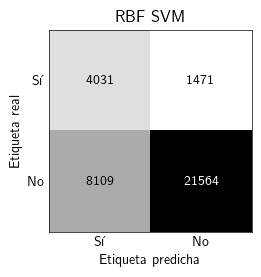

In [30]:
cu.train_and_evaluate_model(rsvm, X_train_scaled, y_train, X_test_scaled, y_test, 'RBF SVM', pos_class, neg_class)

# Regresión Logística

In [31]:
lr = LogisticRegression(max_iter=1000)
C_range = np.logspace(-3, 3, 7)
params = {'C': C_range}
best_lr = GridSearchCV(lr,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
best_lr.fit(X_train_scaled, y_train)
best_mcc = best_lr.best_score_
best_C = best_lr.best_params_['C']
print(f'Best MCC: {best_mcc}, best C: {best_C}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END C=0.001; accuracy: (test=0.724) matthews_corrcoef: (test=0.449) total time=   0.1s
[CV 1/10] END C=0.01; accuracy: (test=0.722) matthews_corrcoef: (test=0.445) total time=   0.1s
[CV 7/10] END C=0.01; accuracy: (test=0.725) matthews_corrcoef: (test=0.451) total time=   0.2s
[CV 9/10] END C=0.01; accuracy: (test=0.718) matthews_corrcoef: (test=0.436) total time=   0.1s
[CV 10/10] END C=0.01; accuracy: (test=0.720) matthews_corrcoef: (test=0.440) total time=   0.2s
[CV 4/10] END C=0.001; accuracy: (test=0.718) matthews_corrcoef: (test=0.437) total time=   0.3s
[CV 10/10] END C=0.001; accuracy: (test=0.720) matthews_corrcoef: (test=0.440) total time=   0.3s
[CV 3/10] END C=0.001; accuracy: (test=0.723) matthews_corrcoef: (test=0.447) total time=   0.3s
[CV 5/10] END C=0.001; accuracy: (test=0.721) matthews_corrcoef: (test=0.442) total time=   0.3s
[CV 9/10] END C=0.001; accuracy: (test=0.718) matthews_corrcoef: (te

Curvas de aprendizaje del clasificador Logistic Regression almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.


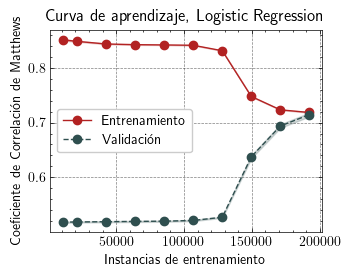

In [32]:
lr = LogisticRegression(C=best_C, max_iter=1000)
lcu.plot_and_save_learning_curve(lr, 'Logistic Regression', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10)

Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Predicciones del clasificador Logistic Regression almacenadas en resultados/predicciones.csv.
Accuracy: 0.7023
Balanced accuracy: 0.7100
Recall: 0.7212
Specificity: 0.6987
AUC: 0.7212
MCC: 0.3165
Precision: 0.3074
F1-score: 0.4311


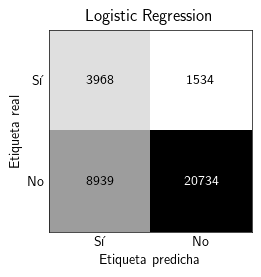

In [33]:
cu.train_and_evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', pos_class, neg_class)

# Resultados

In [ ]:
#cmu.plot_save_all_conf_matrix(predicciones,[pos_class[0],neg_class[0]] ,[pos_class[1],neg_class[1]])

In [3]:
resultados = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'resultados.csv')))
resultados.sort_values(by='Accuracy', ascending=False, inplace=True)
markdown_table = resultados.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)

| Classifier          |   Accuracy |   Balanced_accuracy |   Recall |   Specificity |    AUC |    MCC |   Precision |   F1-score |
|:--------------------|-----------:|--------------------:|---------:|--------------:|-------:|-------:|------------:|-----------:|
| GBM                 |     0.8681 |              0.7104 |   0.4807 |        0.9400 | 0.7104 | 0.4608 |      0.5976 |     0.5328 |
| Decision Tree       |     0.8302 |              0.6743 |   0.4475 |        0.9011 | 0.6743 | 0.3514 |      0.4563 |     0.4518 |
| 1-NN                |     0.7997 |              0.6814 |   0.5093 |        0.8536 | 0.6814 | 0.3276 |      0.3921 |     0.4430 |
| Random Forest       |     0.7945 |              0.7637 |   0.7188 |        0.8085 | 0.7637 | 0.4295 |      0.4104 |     0.5225 |
| MLP                 |     0.7440 |              0.7366 |   0.7259 |        0.7473 | 0.7366 | 0.3665 |      0.3475 |     0.4700 |
| RBF SVM             |     0.7276 |              0.7297 |   0.7326 |        0.7267

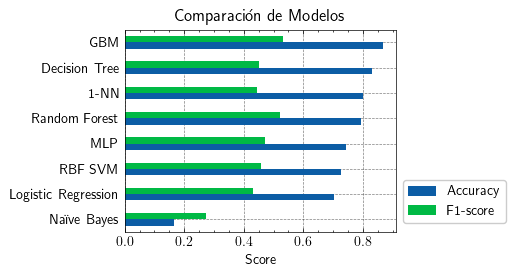

In [10]:
cu.plot_scores(resultados,['Accuracy','F1-score'], ['Accuracy','F1-score'], 'Accuracy', 'Comparación de Modelos')

Learning curves de validación de todos los clasificadores

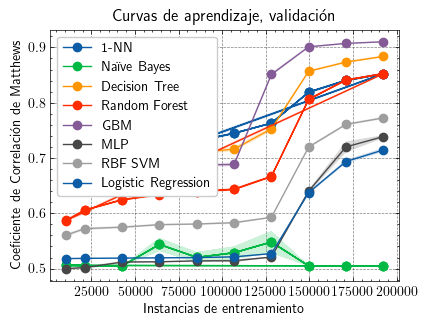

In [5]:
lcu.plot_and_save_all_learning_curves()